In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scoring_code import incr_act_top10

import xgboost as xgb
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

# Clean Data
Features with more than 70% NAs within the feature will be dropped

In [2]:
data = pd.read_parquet('data/training_data.parquet')
features = pd.read_csv('data/ordered_feature_dictionary.csv')
feature_names = features['Feature Name'].values
data = data[feature_names]

In [3]:
to_drop = data.columns[data.isna().sum() >= (len(data.index) * 0.7)]
data = data.drop(to_drop, axis=1)

# data.describe(include='all').to_csv('data/descriptive_stats.csv')

In [4]:
data.head()

,customer,merchant,ind_recommended,activation,customer_profile_01,customer_profile_02,customer_profile_03,customer_profile_04,customer_spend_01,customer_spend_02,customer_spend_03,customer_spend_04,customer_spend_05,customer_spend_06,customer_spend_07,customer_spend_13,customer_spend_16,customer_spend_18,customer_spend_19,customer_digital_activity_01,customer_digital_activity_02,customer_digital_activity_03,customer_digital_activity_05,customer_digital_activity_06,customer_digital_activity_10,customer_digital_activity_11,customer_digital_activity_12,customer_digital_activity_13,customer_digital_activity_14,customer_digital_activity_15,customer_digital_activity_16,customer_digital_activity_17,customer_digital_activity_20,customer_digital_activity_21,customer_digital_activity_22,customer_industry_spend_01,customer_industry_spend_02,customer_industry_spend_03,customer_industry_spend_04,customer_industry_spend_05,customer_merchant_03,distance_01,distance_02,distance_03,distance_04,distance_05,merchant_profile_01,merchant_profile_02,merchant_profile_03,merchant_spend_01,merchant_spend_02,merchant_spend_03,merchant_spend_04,merchant_spend_05,merchant_spend_06,merchant_spend_07,merchant_spend_08,merchant_spend_09,merchant_spend_10
0,168972,152285,0,0,5466.06,1700.00,58.434969,86.0,107.215862,14.0,133.0,4477.0,29719.09,782.0,306.0,3.0,1.0,0.714531,20.85,0.000000,32.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444,0.017921,0.000468,26.686594,74.0,3682.75,138.0,111.0,0.905510,0.307692,1.219756,13.0,4.000000,15.856826,101.0,0.157534,65923.0,29.781042,43.0,0.0,0.0,0.0,32.0,1429.49,48.0,49466.0,29.180
1,212404,39032,0,0,781.56,597.41,5.392089,125.0,35.552000,2.0,8.0,17577.0,1051.40,52.0,43.0,1.0,1.0,0.871597,24.81,0.419355,7.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.928261,3.0,1171.35,23.0,17.0,0.961583,3.808333,6.998555,1.0,3.808333,6.998555,403.0,0.084416,7801.0,34.643313,97.0,0.0,0.0,0.0,15.0,5646.86,163.0,3638.0,28.465
2,225178,7439,0,0,1457.84,1200.00,33.780445,180.0,31.623103,11.0,62.0,49494.0,4695.22,196.0,136.0,1.0,2.0,0.076536,32.26,0.836364,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,48.837872,19.0,2295.38,47.0,42.0,0.327672,NaN,0.129853,13.5,NaN,1.753009,406.0,0.240000,12868.0,1731.000000,2.0,1731.0,2.0,2.0,8.0,3462.00,2.0,3912.0,421.500
3,183948,485069,0,0,351.22,500.00,37.340085,134.0,112.277391,16.0,33.0,NaN,5190.94,167.0,112.0,NaN,NaN,NaN,NaN,0.952381,28.666667,0.0,1.0,4.0,20.0,19.0,19.0,13.0,19.0,7.0,3.0,0.0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.769936,NaN,NaN,NaN,2.000000,9.000063,326.0,0.187500,23553.0,54.800000,4.0,0.0,0.0,0.0,62.0,274.00,5.0,28919.0,50.000
4,210107,536004,1,0,831.67,99.00,77.794164,114.0,448.427273,5.0,8.0,NaN,11713.96,33.0,28.0,NaN,NaN,NaN,NaN,0.754386,15.000000,0.0,1.0,2.0,15.0,15.0,15.0,7.0,15.0,4.0,3.0,10.0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500000,1.767939,326.0,0.428571,308.0,166.000000,1.0,0.0,0.0,0.0,74.0,166.00,1.0,1086.0,69.509


# Initial XGBoost Trial

In [ ]:
# REPLACE W FINAL IMPUTATIONS

# Handle missing values if necessary
# For example, you can fill NaN values with the mean of the column
# data.fillna(data.mean(), inplace=True)

In [5]:
# Feature and label definition
data['new_target'] = ((data['ind_recommended'] == data['activation'])).astype(int)

# Proceed with the original architecture using 'new_target' as the variable to predict
X = data.drop(columns=['customer', 'merchant', 'ind_recommended', 'activation', 'new_target'])
y = data['new_target']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the model
model.fit(X_train, y_train)

# Predict the probability of activation on the validation set
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

# Add predictions back to the validation data
X_valid['predicted_score'] = y_valid_pred_proba

# Add the customer and merchant columns back for scoring
X_valid['customer'] = data.loc[X_valid.index, 'customer']
X_valid['merchant'] = data.loc[X_valid.index, 'merchant']
X_valid['ind_recommended'] = data.loc[X_valid.index, 'ind_recommended']
X_valid['activation'] = y_valid

# Calculate the Incremental Activation Rate using the provided function
incremental_activation_rate = incr_act_top10(input_df=X_valid, pred_col='predicted_score')

print('Incremental Activation Rate:', incremental_activation_rate)

# You can save your model using joblib or pickle if needed
# import joblib
# joblib.dump(model, 'your_model_filename.joblib')


   ind_recommended  avg_30d_act
0                0     0.994787
1                1     0.006027
Incremental Activation Rate: -0.9887597827632884


<AxesSubplot:ylabel='Count'>

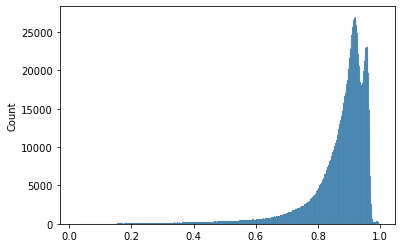

In [7]:
sns.histplot(y_valid_pred_proba)

In [9]:
data['ind_recommended'].value_counts()

0    10682909
1     1547069
Name: ind_recommended, dtype: int64

In [10]:
data['activation'].value_counts()

0    12159962
1       70016
Name: activation, dtype: int64

In [11]:
data['new_target'].value_counts()

1    10632579
0     1597399
Name: new_target, dtype: int64

Class imbalance an issue with this dataset, will be trying out SMOTE and class weighting in the following cells to see if there are any improvements to the predictions made.

But these preliminary models are not incorporating any feature engineering or handling of the missing values in some of the features.

## SMOTE
Using SMOTE to oversample the minority class (creates synthetic data based on the available rows)

* SMOTE doesn't handle NaN values natively

In [12]:
from imblearn.over_sampling import SMOTE

# Feature and label definition
X = data.drop(columns=['customer', 'merchant', 'ind_recommended', 'activation', 'new_target'])
y = data['new_target']

print('Applying SMOTE...')
# Apply SMOTE only on training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# Now split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

print('Training the model...')
# Train the model
model.fit(X_train, y_train)

# Predict the probability of activation on the validation set
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

# Add predictions back to the validation data
X_valid['predicted_score'] = y_valid_pred_proba

# Add the customer and merchant columns back for scoring
X_valid['customer'] = data.loc[X_valid.index, 'customer']
X_valid['merchant'] = data.loc[X_valid.index, 'merchant']
X_valid['ind_recommended'] = data.loc[X_valid.index, 'ind_recommended']
X_valid['activation'] = y_valid

# Calculate the Incremental Activation Rate using the provided function
incremental_activation_rate = incr_act_top10(input_df=X_valid, pred_col='predicted_score')

print('Incremental Activation Rate:', incremental_activation_rate)

Applying SMOTE...


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Adjusting Class Weights
- defined within XGBoost itself

In [13]:
from sklearn.utils import class_weight

# Feature and label definition
data['new_target'] = ((data['ind_recommended'] == data['activation'])).astype(int)

# Proceed with the original architecture using 'new_target' as the variable to predict
X = data.drop(columns=['customer', 'merchant', 'ind_recommended', 'activation', 'new_target'])
y = data['new_target']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Define XGBoost model with class weights
model = xgb.XGBClassifier(scale_pos_weight=class_weights[1], objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the model
print('Training the model...')
model.fit(X_train, y_train)

# Predict the probability of activation on the validation set
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

# Add predictions back to the validation data
X_valid['predicted_score'] = y_valid_pred_proba

# Add the customer and merchant columns back for scoring
X_valid['customer'] = data.loc[X_valid.index, 'customer']
X_valid['merchant'] = data.loc[X_valid.index, 'merchant']
X_valid['ind_recommended'] = data.loc[X_valid.index, 'ind_recommended']
X_valid['activation'] = y_valid

# Calculate the Incremental Activation Rate using the provided function
incremental_activation_rate = incr_act_top10(input_df=X_valid, pred_col='predicted_score')

print('Incremental Activation Rate:', incremental_activation_rate)


Training the model...
   ind_recommended  avg_30d_act
0                0     0.994776
1                1     0.006035
Incremental Activation Rate: -0.9887416646656048
